## Disclaimer
Die Modelle sind in der Begleitarbeit erklärt, und die Funktionen ohnehin nur Nutztiere. Wenn du dir rum Gespiele mit Variablen und Keras befehlen sparen willst, kannst du das Trainieren der Modelle und das definieren sämtlicher Funktionen auch einfach überspringen, und direkt die in der Begleitarbeit erklärten Anwendungen stresstesten. Klicke dafür [hier](#Anwendungen).

# Implementierung

## Imports und Funktionsdefinitionen

In [8]:
# Import all librarys
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

datasets = {
    "mnist": tf.keras.datasets.mnist,
    "fashion_mnist": tf.keras.datasets.fashion_mnist,
}

In [7]:
def reduce_dimension(model):
    ae_out = model.predict([x_test[n].reshape(-1,28,28,1)])[0]

    b = min(layer.units for layer in model.layers if isinstance(layer, keras.layers.Dense))
    dense_layers = [(i, layer.units) for i, layer in enumerate(model.layers) if isinstance(layer, keras.layers.Dense)]
    index_of_smallest = min(dense_layers, key=lambda x: x[1])[0]
    
    #Only looking at the Encoder Part
    encoder_model = keras.Model(
        inputs=model.input, 
        outputs=model.get_layer(index=index_of_smallest).output)  
    
    #Choosing the right encoded picture
    encoded_images = encoder_model.predict(x_test)  
    encoded_image = encoded_images[n].reshape(int(b**0.5), int(b**0.5))  
    
    print(f"We reduced the Data to {100*(b/number_of_features):.2}% of its original size, while having those results")
    plt.tight_layout() 

    plt.imshow(x_test[n], cmap="grey")
    plt.title("Image")
    plt.show()
    
    plt.imshow(encoded_image, cmap='gray')
    plt.title("Encoded Image")
    plt.show()
    
    plt.imshow(ae_out, cmap="grey")
    plt.title("Decoded Image")
    plt.show

In [236]:
#Defining the Anomaly Detection 
def MSE(x, y):
    #y = ae_out(x)
    sum = 0
    for i in range(0,28):
        for j in range(0,28):
            sum += (x[i,j] - ae_out[i,j,0])**2
    return(sum/number_of_features)

def detect_anomaly(x_test, modell):
    y_predict = modell.predict(x_test.reshape(-1, 28, 28, 1))
    x_test_list = [x_test[i] for i in range(x_test.shape[0])]
    y_predict_list = [ y_predict[i] for i in range(y_predict.shape[0]) ]

    RE = 0
    RE_ind = 0

    for i in range(len(x_test_list)):
        if MSE(x_test_list[i],y_predict_list[i]) > RE:
            RE = MSE(x_test_list[i],y_predict_list[i])
            RE_ind = i

    return [RE, RE_ind]

In [329]:
def find_standout(modell):
    [RE, RE_ind] = detect_anomaly(x_test, modell)

    print(f"Our Autoencoder thinks, the test tata at index {RE_ind} stand out. It looks like this")
    plt.imshow(x_test[RE_ind], cmap="grey")
    plt.title("The Standout")
    plt.show()

    plotme = modell.predict([x_test[RE_ind].reshape(-1,28,28,1)])[0]
    
    print(f"It has a the highest reconstructionerrror with RE={RE} and the reconstruction looks like this:")
    plt.imshow(plotme, cmap="grey")
    plt.title("It's Reconstruct")
    plt.show()

In [254]:
#Defining Noise Function

def add_noise(img, random_chance):
    noisy = []
    for row in img:
        new_row = []
        for pix in row:
            if random.choice(range(100)) <= random_chance:
                new_val = random.uniform(0,1)
                new_row.append(new_val)
            else:
                new_row.append(pix)
        noisy.append(new_row)
    return np.array(noisy)


In [322]:
def reduce_noise(noise_ratio, modell):
    #Computing Noise sutff
    noisy = add_noise(x_test[n], noise_ratio * 100)
    noisy_out = modell.predict([noisy.reshape(-1,28,28,1)])[0]

    #Printing the Results
    print(f"Image with Noise ({noise_ratio * 100} % Noise Ratio)")
    plt.imshow(noisy, cmap="grey")
    plt.title("Noisy Image")
    plt.show()
    
    plt.imshow(noisy_out, cmap="grey")
    plt.title("Reconstruction from noisy image")
    plt.show()

In [240]:
def test_anomaly(wrong_data, coruption_index, modell):
    print(modell)
    # Testing if datasets are different
    if data == wrong_data:
        print("Data and Wrong data have to be different")
    
    #Adding the anomaly
    (x_trainf, y_trainf), (x_testf,y_testf) = datasets[wrong_data].load_data()
    x_corupted = x_test.copy()
    x_corupted[coruption_index] = x_testf[coruption_index]
    
    #Doing the Computation
    [RE, RE_ind] = detect_anomaly(x_corupted, modell)
    
    dec_pred_corupt = modell.predict([x_corupted[RE_ind].reshape(-1,28,28,1)])[0]
    
    RE_anomaly = MSE(x_corupted[coruption_index], modell.predict([x_corupted[coruption_index].reshape(-1,28,28,1)])[0])

    dec_corupt = modell.predict([x_corupted[coruption_index].reshape(-1,28,28,1)])[0]
    
    #Printing the Results
    
    print(f"Our Autoencoder thinks, that the anomaly seems to be at Index {RE_ind} looks like this:")
    plt.imshow(x_corupted[RE_ind], cmap="grey")
    plt.show()
    
    print(f"It has a the highest reconstructionerrror with RE={round(RE)} and the reconstruction(attempt) looks like this:")
    plt.imshow(dec_pred_corupt, cmap="grey")
    plt.show()


    if RE_ind != coruption_index:
        print("BUT HE IS WRONG")
        
        print(f"The actual anomyly is at index {coruption_index} and looks like this")
        plt.imshow(x_corupted[coruption_index], cmap="grey")
        plt.show()
        
        print(f"It only has an RE of {round(RE_anomaly)} and its reconstruction looks like this")
        plt.imshow(dec_corupt, cmap="grey")
        plt.show()
    else:
        print("AND HE IS RIGHT!")
    
    plt.tight_layout() 

## Trainieren der Modelle

In [241]:
# Modulare Parameter

#Training des Modells
acti = "sigmoid" #Aktivierungsfunktion
lossi = "mse" #Loss Funktion
n_epochs = 3
n_batch_size = 32
data = "fashion_mnist" 

In [242]:
# Importing Data and looking at it
(x_train, y_train), (x_test,y_test) = datasets[data].load_data()
number_of_features = x_train[1].shape[1]*x_train[1].shape[1]
print(f"numer of features = {number_of_features}")


#Normalizing the Dataset: All vectors now live in the [0,1]^784 "space"
x_train = x_train/255.0 
x_test = x_test/255.0

numer of features = 784


In [243]:
#Defining Model 1

autoencoder1 = keras.Sequential(name="autoencoder1")
autoencoder1.add(keras.Input(shape=(28,28,1), name="img"))
autoencoder1.add(keras.layers.Flatten())
autoencoder1.add(keras.layers.Dense(64, activation=acti))
autoencoder1.add(keras.layers.Dense(784, activation=acti))
autoencoder1.add(keras.layers.Reshape((28,28,1)))

opt = keras.optimizers.Adam(learning_rate=0.01)

autoencoder.summary()

autoencoder1.compile(opt, loss= lossi)

# Training Model 1
autoencoder1.fit(x_train, x_train, epochs=n_epochs, batch_size=n_batch_size, validation_split=0.1) 

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_73 (Dense)            (None, 64)                50240     
                                                                 
 dense_74 (Dense)            (None, 784)               50960     
                                                                 
 reshape_22 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1688/1688 [==============================] - 39s 23ms/step - loss: 0.0219 - val_loss: 0.0153
Epoch 2/3
1688/1688 [==============================] - 39s 23ms/step - loss: 0

In [244]:
#Defining Model 2

autoencoder2 = keras.Sequential(name="autoencoder2")
autoencoder2.add(keras.Input(shape=(28,28,1), name="img"))
autoencoder2.add(keras.layers.Flatten())
autoencoder2.add(keras.layers.Dense(64, activation=acti))
autoencoder2.add(keras.layers.Dense(16, activation=acti))
autoencoder2.add(keras.layers.Dense(64, activation=acti))
autoencoder2.add(keras.layers.Dense(784, activation=acti))
autoencoder2.add(keras.layers.Reshape((28,28,1)))

opt = keras.optimizers.Adam(learning_rate=0.01)

autoencoder2.summary()

autoencoder2.compile(opt, loss= lossi)

# Training Model 2
autoencoder2.fit(x_train, x_train, epochs=n_epochs + 2, batch_size=n_batch_size, validation_split=0.1) 

Model: "autoencoder2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 784)               0         
                                                                 
 dense_95 (Dense)            (None, 64)                50240     
                                                                 
 dense_96 (Dense)            (None, 16)                1040      
                                                                 
 dense_97 (Dense)            (None, 64)                1088      
                                                                 
 dense_98 (Dense)            (None, 784)               50960     
                                                                 
 reshape_28 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 103,328
Trainable params: 103,328
Non-tr

In [292]:
#Defining Model 3

autoencoder3 = keras.Sequential(name="autoencoder3")
autoencoder3.add(keras.Input(shape=(28,28,1), name="img"))
autoencoder3.add(keras.layers.Flatten())
autoencoder3.add(keras.layers.Dense(64, activation=acti))
autoencoder3.add(keras.layers.Dense(16, activation=acti))
autoencoder3.add(keras.layers.Dense(4,activation=acti))
autoencoder3.add(keras.layers.Dense(16,activation=acti))
autoencoder3.add(keras.layers.Dense(64, activation=acti))
autoencoder3.add(keras.layers.Dense(784, activation=acti))
autoencoder3.add(keras.layers.Reshape((28,28,1)))

opt = keras.optimizers.Adam(learning_rate=0.01)

autoencoder3.summary()

autoencoder3.compile(opt, loss= lossi)

# Training Model 3
autoencoder3.fit(x_train, x_train, epochs=n_epochs , batch_size=n_batch_size, validation_split=0.1) 

Model: "autoencoder3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 784)               0         
                                                                 
 dense_119 (Dense)           (None, 64)                50240     
                                                                 
 dense_120 (Dense)           (None, 16)                1040      
                                                                 
 dense_121 (Dense)           (None, 4)                 68        
                                                                 
 dense_122 (Dense)           (None, 16)                80        
                                                                 
 dense_123 (Dense)           (None, 64)                1088      
                                                                 
 dense_124 (Dense)           (None, 784)              

# Anwendungen

### Dimensionsreduktion

313/313 [==============================] - 6s 19ms/step
We reduced the Data to 0.51% of its original size, while having those results


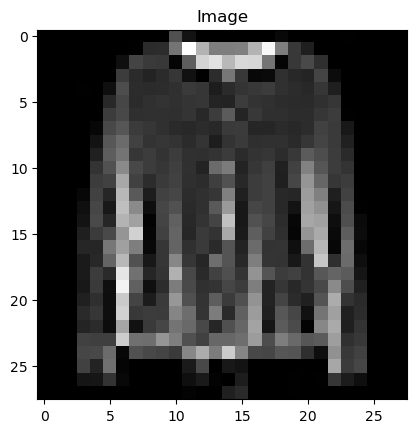

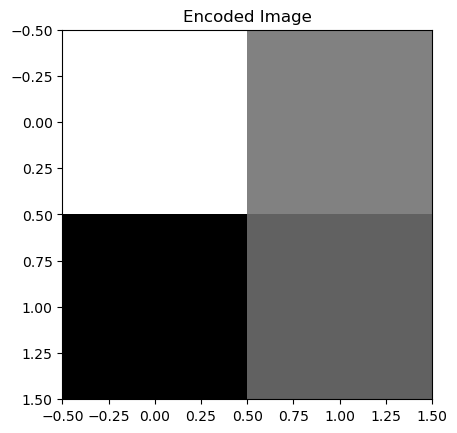

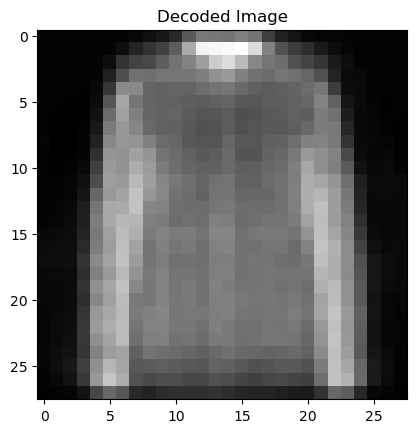

In [320]:
n = 25 #Index of sample
reduce_dimension(autoencoder3)

### Rauschentfernung

1/1 [==============================] - 0s 21ms/step
Image with Noise (50.0 % Noise Ratio)


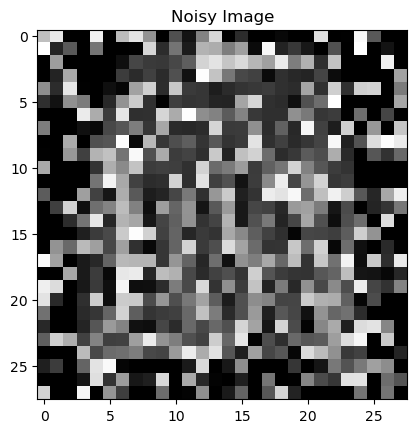

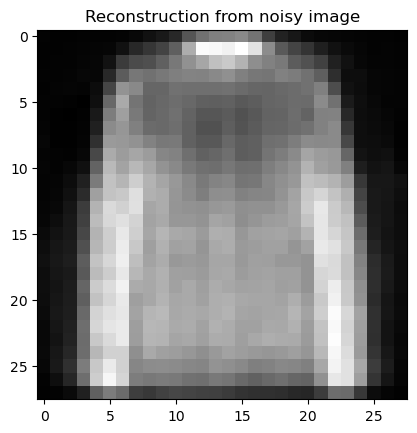

In [325]:
n = 25 #Index of sample
noise_ratio = 0.5
reduce_noise(noise_ratio, autoencoder3)

### Anomaliedetektion

Ohne vorher die Daten zu manipulieren, findet die Anomaliedtetktion einfach den Datenpunkt mit dem größten RE.

313/313 [==============================] - 3s 10ms/step
Our Autoencoder thinks, the test tata at index 5160 stand out. It looks like this


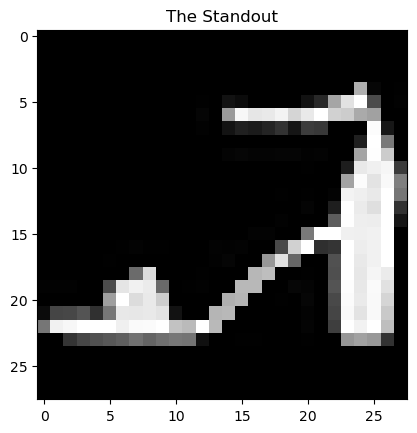

1/1 [==============================] - 0s 17ms/step
It has a the highest reconstructionerrror with RE=0.39112564463364513 and the reconstruction looks like this:


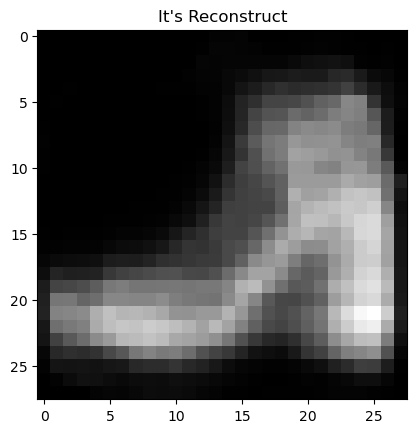

In [330]:
find_standout(autoencoder3)

Hier können die Daten explizit vorher manipuliert werden, um zu sehen, ob der Autoencoder den manipulierten Datenpunkt finden kann.

1/1 [==============================] - 0s 18ms/step
Our Autoencoder thinks, that the anomaly seems to be at Index 72 looks like this:


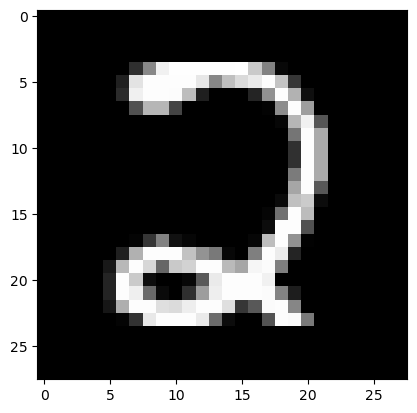

It has a the highest reconstructionerrror with RE=7384 and the reconstruction(attempt) looks like this:


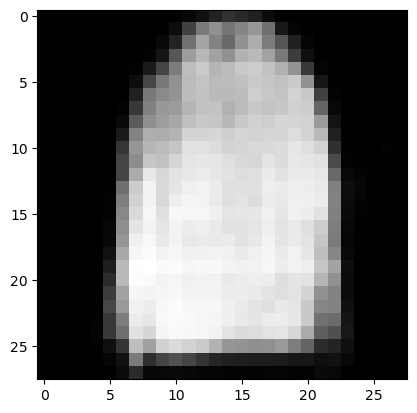

AND HE IS RIGHT!


<Figure size 640x480 with 0 Axes>

In [277]:
coruption_index = 72 #Index of Sample that gets corrupted
wrong_data = "mnist" #Source of Corrupted Sample (should be different from data source, but same size)

test_anomaly(wrong_data, coruption_index, autoencoder2)